In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d, make_smoothing_spline

from astropy import units as u

mpl.rc('font', family='serif', size=16)

In [2]:
import jax
import equinox as eqx
from tinygp.helpers import JAXArray

jax.config.update("jax_enable_x64", True)

In [3]:
def dateformat(ax):
    locator   = mpl.dates.AutoDateLocator()
    formatter = mpl.dates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

In [4]:
def histogram_residuals(mu_ss, mu_gp, var_ss, var_gp):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3), sharey=True)
    ax1.hist(mu_ss-mu_gp)
    ax2.hist(var_ss-var_gp)
    ax1.set(xlabel=r'$\mu_{ss} - \mu_{gp}$', )
    ax2.set(xlabel=r'$\sigma^2_{ss} - \sigma^2_{gp}$');
    fig.tight_layout()
    return fig, (ax1, ax2)

In [5]:
import jax
import jax.numpy as jnp
from jax.scipy.linalg import expm, solve

key = jax.random.PRNGKey(0)

## Import `onefit` to get full GP version of SHO 

In [6]:
import sys
sys.path.insert(0, '/Users/rrubenzahl/Research/Solar/onefit/onefit/')

In [7]:
import importlib
import gpkernels
importlib.reload(gpkernels)
from gpkernels import *

# Kernel definition in `tinygp` and `ssmolgp`

In [8]:
import tinygp
import smolgp

In [9]:
## SHO Kernel
S=2.36
w=0.0195
Q=7.63
sigma = jnp.sqrt(S*w*Q)

qsKernel = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
ssKernel = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
gpKernel = gpkernels.OscillationKernel()

Defaulting to solar values.


In [10]:
## Matern-5/2 Kernel
scale = 600. # sec
sigma = 1.

qsKernel = tinygp.kernels.quasisep.Matern52(scale=scale, sigma=sigma)
ssKernel = smolgp.kernels.Matern52(scale=scale, sigma=sigma)
gpKernel = gpkernels.Matern52Kernel()

In [11]:
%%timeit -n 100
qsKernel = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)

15.1 μs ± 681 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
%%timeit -n 100
ssKernel =smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)

32.4 μs ± 2.38 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Use tinygp to define a 'ground truth' process

In [13]:
# true_kernel = qsKernel

kernel1 = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
kernel2 = tinygp.kernels.quasisep.Matern52(scale=600., sigma=1.)
true_kernel = kernel1 + kernel2

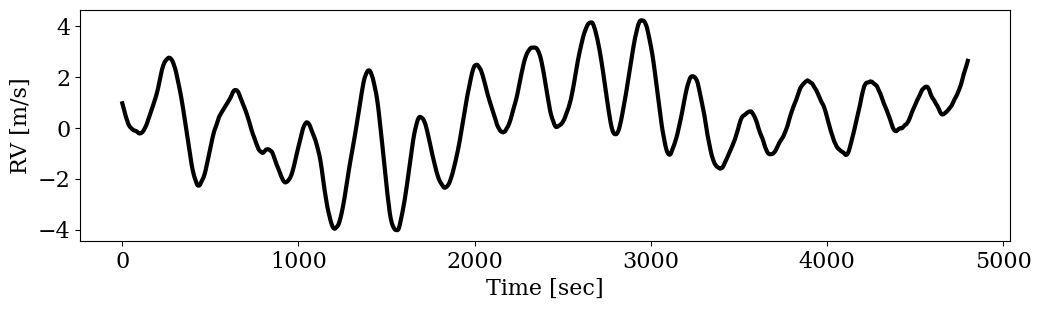

In [14]:
def get_true_gp(tmin, tmax, tunit='s', dt=1):
    t = u.Quantity(jnp.arange(tmin, tmax, dt), tunit).to('s').value
    true_gp = tinygp.GaussianProcess(true_kernel, t)
    # gp.sample adds small random noise for numerical stability
    y_sample = true_gp.sample(key=jax.random.PRNGKey(32)) 
    f = make_smoothing_spline(t, y_sample, lam=10/60)
    return t, f

baseline_minutes = 80
t, f = get_true_gp(0, baseline_minutes, 'min', dt=1/60)
fig, ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(t, f(t), label='Example SHO', color='k', lw=3)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

## Make synthetic observations

In [15]:
#### Simulated dataset
def generate_data(N, yerr=0.3, tmin=None, tmax=None, baseline_minutes=80):

    # Generate true GP over baseline
    t, f = get_true_gp(0, baseline_minutes, 'min', dt=1/60)
    tmin = t.min() if tmin is None else tmin
    tmax = t.max() if tmax is None else tmax

    # Generate synthetic observations (no exposure time)
    t_train = jnp.linspace(tmin, tmax, N+2)[1:-1]
    y_true = f(t_train)
    y_train = y_true + yerr * jax.random.normal(key, shape=(N,))
    return t_train, y_train

In [16]:
np.random.seed(231)

N = 30
yerr = 0.3 # m/s
t_train, y_train = generate_data(N, yerr)

i,di=10,5
delete = jnp.arange(i,i+di,1)
t_train = jnp.delete(t_train, delete)
y_train = jnp.delete(y_train, delete)

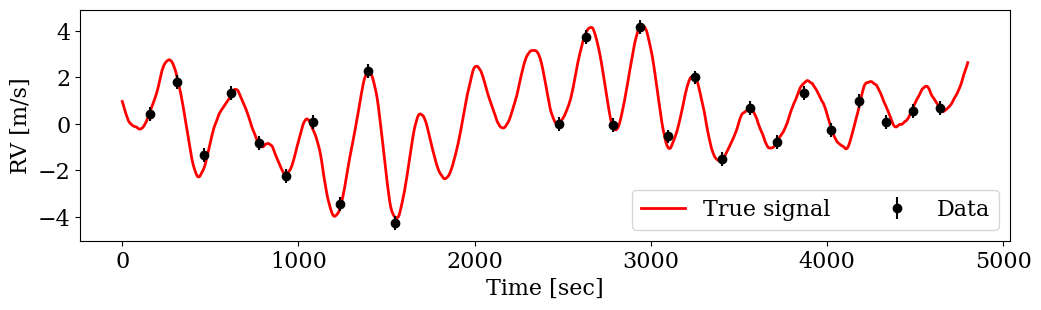

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,3))

ax.plot(t, f(t), label='True signal', color='r', lw=2)
ax.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data')

ax.legend(ncol=2)
ax.set(ylabel='RV [m/s]', xlabel=f'Time [sec]');

In [18]:
def sample_data(N, yerr=0.3):
    return generate_data(N, qsKernel, yerr=yerr)

In [19]:
t_test = jnp.linspace(t.min(), t.max(), 1000)

# Multi-component model

1. build with tinygp, build with smolgp

2. show they give the same likelihood

3. show they give the same conditioned/predictive mean/var

4. test mixture of integrated and regular kernel

## 1a. Build with `ssmolgp`

In [20]:
## SHO
ssm1 = smolgp.kernels.SHO(omega=w, quality=Q, sigma=sigma)
# ssm2 = smolgp.kernels.SHO(omega=0.00234587265, 
#                            quality=1/jnp.sqrt(2), 
#                            sigma=0.329)
ssm2 = smolgp.kernels.Matern52(scale=600., sigma=1.)
ssm = ssm1 + ssm2
# ssm = ssm1 * ssm2
ssm

Sum(
  name='Sum(SHO, Matern52)',
  kernel1=SHO(name='SHO', omega=0.0195, quality=7.63, sigma=1.0, eta=weak_f64[]),
  kernel2=Matern52(name='Matern52', scale=600.0, sigma=1.0, lam=weak_f64[])
)

## 1b. Build with `tinygp`

In [21]:
kernel1 = tinygp.kernels.quasisep.SHO(omega=w, quality=Q, sigma=sigma)
# kernel2 = tinygp.kernels.quasisep.SHO(omega=0.00234587265, 
#                                       quality=1/jnp.sqrt(2), 
#                                       sigma=0.329)
kernel2 = tinygp.kernels.quasisep.Matern52(scale=600., sigma=1.)

kernel = kernel1 + kernel2
# # kernel = kernel1 * kernel2
kernel

Sum(
  kernel1=SHO(omega=0.0195, quality=7.63, sigma=1.0),
  kernel2=Matern52(scale=600.0, sigma=1.0)
)

In [22]:
gp_ss = smolgp.GaussianProcess(kernel=ssm, X=t_train, diag=yerr**2)
gp_qs = tinygp.GaussianProcess(kernel=kernel, X=t_train, diag=yerr**2)

## 2. Likelihoods verification

In [23]:
gp_qs.log_probability(y_train)

Array(-42.86318234, dtype=float64)

In [24]:
gp_ss.log_probability(y_train)

Array(-42.86318234, dtype=float64)

In [25]:
gp_qs.log_probability(y_train) - gp_ss.log_probability(y_train)

Array(1.42108547e-14, dtype=float64)

## 3a. Condition verification

In [26]:
## Throws an error if X_test is not given (TODO: open issue in tinygp)
condGP_qs = gp_qs.condition(y_train, t_train).gp
llh, condGP_ss = gp_ss.condition(y_train)

# ## also going to have to do a check w/ to_dense in SSM predict
# condGP2.predict(t_test, return_var=True)

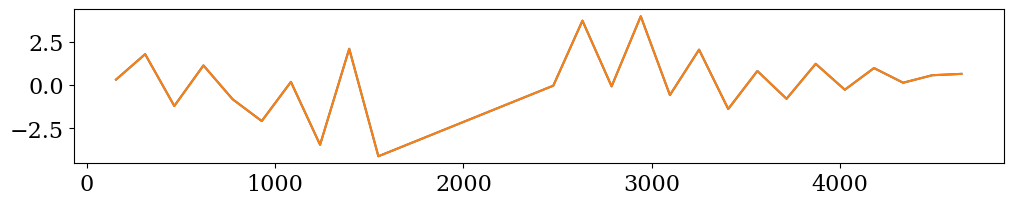

In [27]:
plt.figure(figsize=(12,2))
plt.plot(t_train, condGP_qs.loc)
plt.plot(t_train, condGP_ss.loc)

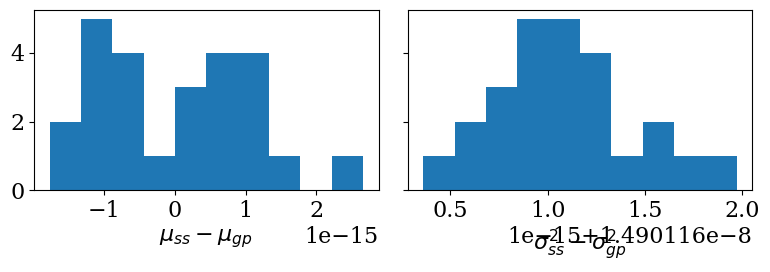

In [28]:
fig, (ax1, ax2) = histogram_residuals(condGP_qs.loc, condGP_ss.loc,
                                      condGP_qs.variance, condGP_ss.variance)

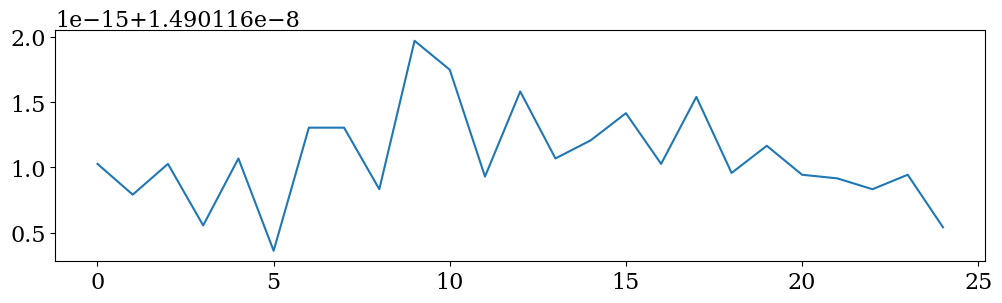

In [29]:
plt.figure(figsize=(12,3))
plt.plot(condGP_qs.variance-condGP_ss.variance)

In [30]:
# gp_qs.predict(y_train) # throws an error if X_test is not given

# The problem is with this line, 
# something to do with `a` which comes from p, q, a = self.lower
# gp_qs.solver.factor.inv()

## 3b. Prediction verification

In [31]:
mu_qs, var_qs = gp_qs.predict(y_train, t_test, return_var=True)

In [32]:
mu_ss, var_ss = condGP_ss.predict(t_test, return_var=True)
# mu_ss, var_ss = gp_ss.predict(t_test, y_train, return_var=True)

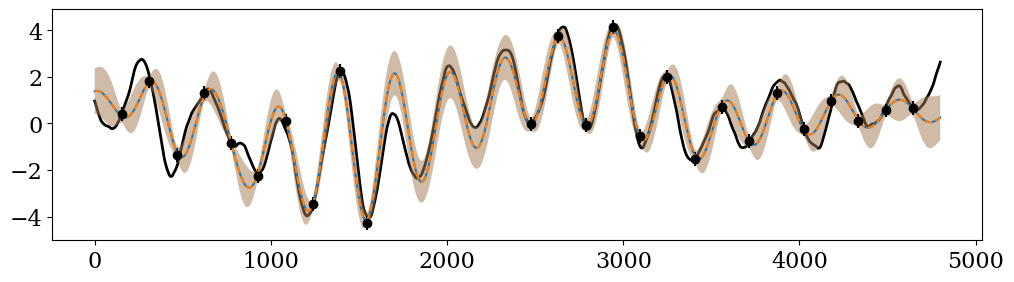

In [33]:
plt.figure(figsize=(12,3))

plt.plot(t, f(t), label='True signal', color='k', lw=2, zorder=-10)
plt.errorbar(t_train, y_train, yerr, fmt='o', color='k', label='Data', alpha=1)

plt.plot(t_test, mu_qs)
plt.fill_between(t_test, mu_qs-jnp.sqrt(var_qs), mu_qs+jnp.sqrt(var_qs), alpha=0.3)

plt.plot(t_test, mu_ss, ls='--')
plt.fill_between(t_test, mu_ss-jnp.sqrt(var_ss), mu_ss+jnp.sqrt(var_ss), alpha=0.3)

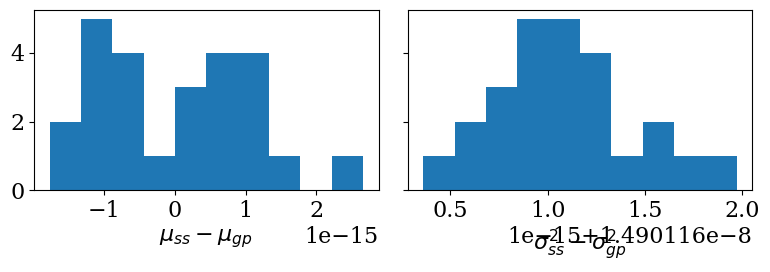

In [34]:
fig, (ax1, ax2) = histogram_residuals(condGP_qs.loc, condGP_ss.loc,
                                      condGP_qs.variance, condGP_ss.variance)

## Predict at a single component kernel

In [35]:
from smolgp.kernels import Sum, Product

In [36]:
from smolgp.kernels.base import extract_leaf_kernels
from smolgp.gp import assign_unique_kernel_names

In [37]:
testkernel = condGP_ss.kernel#+ssm2*ssm

testkernel = assign_unique_kernel_names(testkernel)

kernels = extract_leaf_kernels(testkernel)
for k, kernel in enumerate(kernels):
    print(kernel.name)

SHO
Matern52


In [38]:
ys, yvars, = condGP_ss.component_means(return_var=True)
mus, vars = condGP_ss.predict_component_means(t_test, return_var=True)

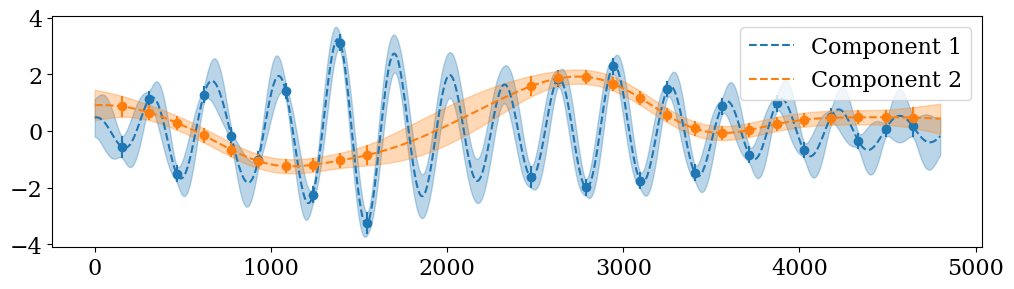

In [40]:
plt.figure(figsize=(12,3))
for k in range(len(ys)):
    plt.errorbar(t_train, ys[k], yerr=jnp.sqrt(yvars[k]), fmt='o', color=f'C{k}')

    plt.plot(t_test, mus[k], label=f'Component {k+1}', linestyle='--', color=f'C{k}')
    plt.fill_between(t_test,
                     mus[k]-jnp.sqrt(vars[k]),
                     mus[k]+jnp.sqrt(vars[k]), alpha=0.3, color=f'C{k}')

plt.legend();

In [ ]:
# TODO: when making sum/product, 
# auto-enumerate duplicate names?

In [ ]:
condGP_ss.kernel.name

'Sum(SHO, Matern52)'

In [ ]:
condGP_ss.kernel.observation_model(jnp.array([0]), component='SHO')

Array([[1, 0, 0, 0, 0]], dtype=int64)

In [ ]:
mus, vars = condGP_ss.predict(t_test, 
            #    return_full_state=True,
                return_components=True, 
                return_var=True)
mu1, mu2 = mus

TypeError: GaussianProcess.predict() got an unexpected keyword argument 'return_components'

In [ ]:
# plt.plot(t_train, mean1)
# plt.plot(t_train, mean2)z
plt.plot(t_test, mu1)
plt.plot(t_test, mu2)

NameError: name 'mu1' is not defined

In [ ]:
y_ss = condGP_ss.loc
y_gp = condGP_qs.loc
yerr_ss = jnp.sqrt(condGP_ss.variance)
yerr_gp = jnp.sqrt(condGP_qs.variance)

mu_gp = mu_qs
std_gp = jnp.sqrt(var_qs)
std_ss = jnp.sqrt(var_ss)

### Plot

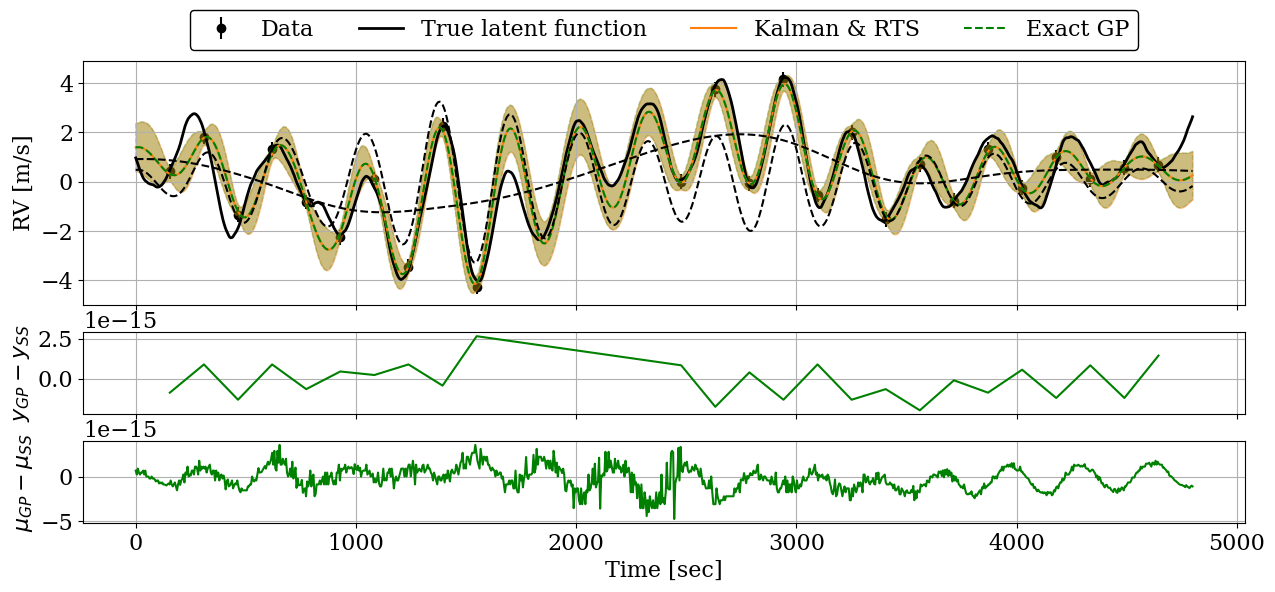

In [ ]:
fig, (ax, rax1, rax2) = plt.subplots(3,1, figsize=(15, 6), sharex=True, gridspec_kw={'height_ratios':[3,1,1]})

cobs = 'k' # 'w'
ctrue = 'k'
cgp  = 'g'
ckal = 'C0'
crts = 'C1'

## Data and true signal
l1 = ax.errorbar(t_train, y_train, yerr, fmt='o', zorder=0, color=cobs, label="Data")
l2, = ax.plot(t, f(t), color=ctrue, lw=2, label="True latent function")

## Test predictions
l4, = ax.plot(t_test, mu_ss, color=crts,  ls='-', label="Kalman & RTS")
ax.fill_between(t_test, mu_ss-std_ss, mu_ss+std_ss, ls='-', color=crts, alpha=0.4)

l5, = ax.plot(t_test, mu_gp,  color=cgp,   ls='--',  label="Exact GP")
ax.fill_between(t_test, mu_gp-std_gp, mu_gp+std_gp, ls='--', color=cgp, alpha=0.2)

## Component signals
ax.plot(t_test, mu1, color='k', ls='--')
ax.plot(t_test, mu2, color='k', ls='--')

lines = [l1, l2, l4, l5]
ax.legend(lines, [l.get_label() for l in lines],
            ncol=4,# loc='upper center', #fontsize=14,
            loc='lower center', bbox_to_anchor=[0.5,1],
              framealpha=1, edgecolor='k', 
            # facecolor='#232323' 
            )
# ax.set_title("State-Space GP vs. Exact GP")
ax.set(ylabel='RV [m/s]', )#xlim=[max(t_test.min(), t.min().to(kernel.tunit).value),
                        #  min(t_test.max(), t.max().to(kernel.tunit).value)])
# ax.set_ylim(f(t).min()-.2, f(t).max()+1)
ax.grid()

# rax.plot(t_train, y_kal-y_true, ckal, ls=':')
rax1.plot(t_train, y_gp-y_ss,  cgp , ls='-')
# rax1.plot(t_train, )

mu_true = f(t_test/60)
rax2.plot(t_test, mu_gp-mu_ss, c=cgp , ls='-')
# rax2.fill_between(t_test, (mu_ss-std_ss) - (mu_gp-std_gp), 
#                           (mu_ss+std_ss) - (mu_gp+std_gp), 
#                   ls='--', color='k', alpha=0.2)

rax1.set(ylabel=r'$y_{GP}-y_{SS}$')
rax2.set(xlabel='Time [sec]', ylabel=r'$\mu_{GP}-\mu_{SS}$')

rax1.grid();rax2.grid();

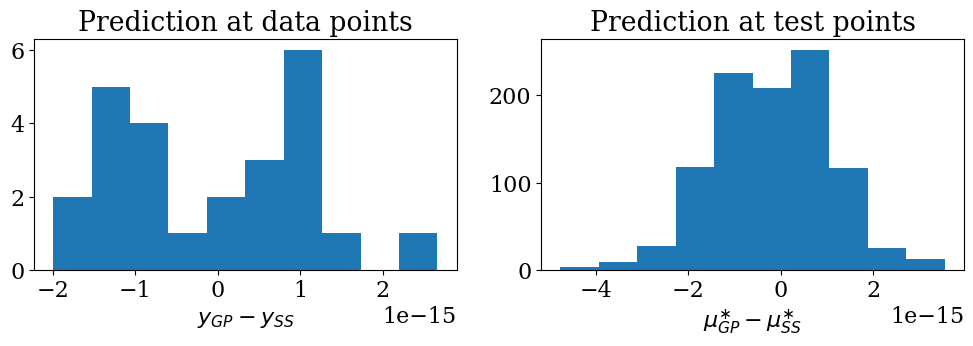

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 3))
ax1.hist(y_gp - y_ss);
# ax1.hist(yvar_gp - yvar_ss);
ax1.set(title='Prediction at data points', xlabel='$y_{GP} - y_{SS}$')

ax2.hist(mu_gp - mu_ss);
# ax2.hist(var_gp - var_ss);
ax2.set(title='Prediction at test points', xlabel=r'$\mu^{\ast}_{GP} - \mu^{\ast}_{SS}$');